# Lab -3 - CSCN8010

# Dogs vs Cats Classification: Fine-Tuning Pretrained Models

**Purpose:**  
Fine-tune a pre-trained VGG16 model and train a custom CNN on a subset of the Dogs vs Cats dataset. Evaluate and compare their performances.

---

## 1. Setup and Data Preparation

We will download the dataset, extract 5,000 images balanced between cats and dogs, and prepare data loaders.


In [24]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, callbacks

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.19.0


### Download and Prepare Subset of Dogs vs Cats Dataset

**Note:**  
- The full dataset has 25,000 images (12,500 cats and 12,500 dogs).  
- For this lab, we use only 5,000 images (2,500 cats + 2,500 dogs).  
- Organize images into train and validation directories with balanced classes.


In [25]:
import os

# List first 10 files in Data/train/cats (example)
train_cats_dir = './Data/train/cats'
files = os.listdir(train_cats_dir)
print(files[:10])  # first 10 cat images

# Similarly, for dogs
train_dogs_dir = './Data/train/dogs'
files = os.listdir(train_dogs_dir)
print(files[:10])  # first 10 dog images


['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg', 'dog.10000.jpg', 'dog.10001.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg']


## Displaying the total of Images division for Cats and Dogs

Train set counts: {'cats': 2000, 'dogs': 2000}


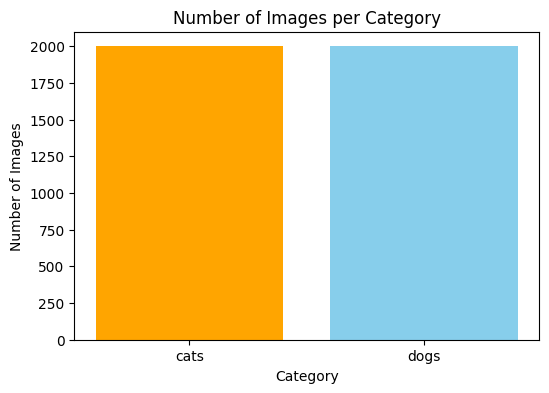

In [26]:
import os
import matplotlib.pyplot as plt

# Define the train directory path
train_dir = './Data/train'

# Function to count images in cats and dogs folders
def count_images(directory):
    counts = {}
    for category in ['cats', 'dogs']:
        category_dir = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

# Get counts for train folder
train_counts = count_images(train_dir)
print("Train set counts:", train_counts)

# Plot the counts as bar chart
categories = list(train_counts.keys())
counts = list(train_counts.values())

plt.figure(figsize=(6,4))
plt.bar(categories, counts, color=['orange', 'skyblue'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()


## 2. Exploratory Data Analysis (EDA)

Let's look at some sample images and the distribution of classes. I have changes the resolution of all the images to a common resolution


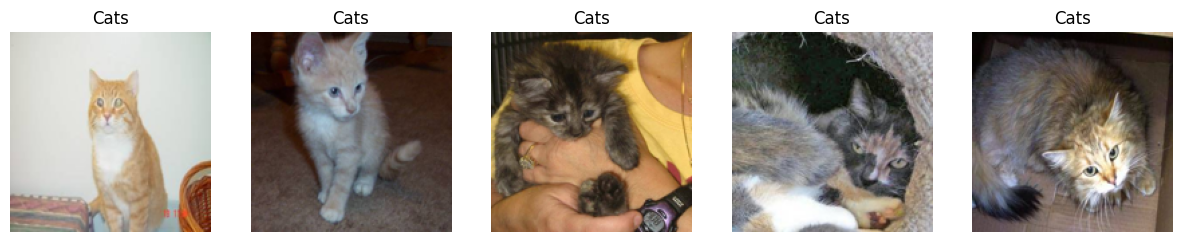

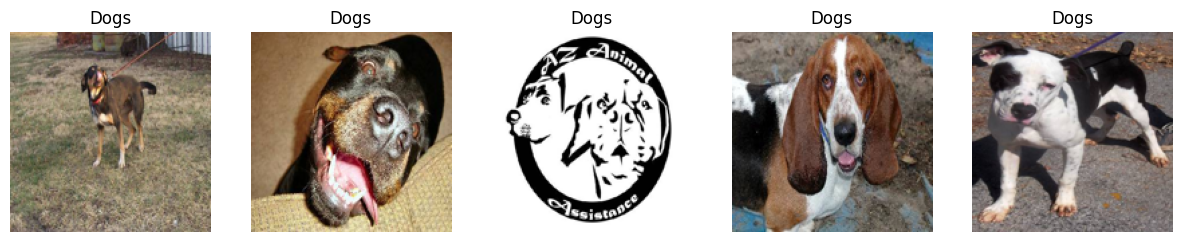

In [27]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def resize_image(img_path, target_size=(150, 150)):
    img = Image.open(img_path)
    if img.size != target_size[::-1]:  # PIL size is (width, height)
        img = img.resize(target_size)
    return np.array(img)

def plot_samples(directory, category, target_size=(150, 150), n_samples=5):
    category_dir = os.path.join(directory, category)
    sample_images = random.sample(os.listdir(category_dir), n_samples)
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(category_dir, img_name)
        img = resize_image(img_path, target_size)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img)
        plt.title(category.capitalize())
        plt.axis('off')
    plt.show()

train_dir = './Data/train'

plot_samples(train_dir, 'cats', target_size=(150, 150), n_samples=5)
plot_samples(train_dir, 'dogs', target_size=(150, 150), n_samples=5)


In [28]:
# Check counts per category for train and validation sets
def count_images(directory):
    counts = {}
    for category in ['cats', 'dogs']:
        category_dir = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

print("Train set counts:", count_images(train_dir))
validation_dir = './Data/validation'  

print("Validation set counts:", count_images(validation_dir))


Train set counts: {'cats': 2000, 'dogs': 2000}
Validation set counts: {'cats': 500, 'dogs': 500}


## 3. Data Generators with Augmentation

We use `ImageDataGenerator` for training (with augmentation) and validation (only rescaling).


In [29]:
batch_size = 32
image_size = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # shuffle=False for consistent evaluation


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 4. Define and Train a Custom CNN Model


In [30]:
# Define simple CNN architecture
def create_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

custom_cnn = create_custom_cnn()
custom_cnn.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train Custom CNN with EarlyStopping and ModelCheckpoint


In [31]:
from tensorflow.keras import callbacks

checkpoint_path_cnn = 'fast_custom_cnn.h5'
checkpoint_cnn = callbacks.ModelCheckpoint(
    filepath=checkpoint_path_cnn,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history_cnn = custom_cnn.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint_cnn],
    steps_per_epoch=30,
    validation_steps=10,
    verbose=2
)


Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to fast_custom_cnn.h5


30/30 - 54s - 2s/step - accuracy: 0.5250 - loss: 0.7724 - val_accuracy: 0.0000e+00 - val_loss: 0.8749
Epoch 2/20

Epoch 2: val_accuracy improved from 0.00000 to 0.99687, saving model to fast_custom_cnn.h5


30/30 - 43s - 1s/step - accuracy: 0.5333 - loss: 0.6885 - val_accuracy: 0.9969 - val_loss: 0.6372
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.99687
30/30 - 41s - 1s/step - accuracy: 0.5240 - loss: 0.6902 - val_accuracy: 0.5656 - val_loss: 0.6611
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.99687
30/30 - 43s - 1s/step - accuracy: 0.5542 - loss: 0.6747 - val_accuracy: 0.8281 - val_loss: 0.6112
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.99687
30/30 - 9s - 314ms/step - accuracy: 0.5813 - loss: 0.6535 - val_accuracy: 0.1844 - val_loss: 1.2163
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.99687
30/30 - 43s - 1s/step - accuracy: 0.5833 - loss: 0.6781 - val_accuracy: 0.6500 - val_loss: 0.6462
Epoch 7/20

Epoch 7: val_accuracy did not improve from 0.99687
30/30 - 41s - 1s/step - accuracy: 0.5781 - loss: 0.6676 - val_accuracy: 0.1969 - val_loss: 0.7790
Epoch 8/20

Epoch 8: val_accuracy did not improve from 0.99687
30/30 - 42s - 1s/step - accuracy

## 5. Fine-Tune Pretrained VGG16 Model


In [32]:
# Load VGG16 without top, freeze base layers initially
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_vgg.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Train Top Layers on Frozen Base


In [33]:
checkpoint_path_vgg = 'best_vgg16.h5'
checkpoint_vgg = callbacks.ModelCheckpoint(checkpoint_path_vgg, monitor='val_accuracy', save_best_only=True)
earlystop_vgg = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_vgg = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_vgg, earlystop_vgg])


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6838 - loss: 0.5911 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1788s 14s/step - accuracy: 0.6844 - loss: 0.5902 - val_accuracy: 0.8610 - val_loss: 0.3185
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8240 - loss: 0.3797 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1872s 15s/step - accuracy: 0.8241 - loss: 0.3797 - val_accuracy: 0.8870 - val_loss: 0.2735
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8467 - loss: 0.3342 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1831s 15s/step - accuracy: 0.8467 - loss: 0.3342 - val_accuracy: 0.8920 - val_loss: 0.2525
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1849s 14s/step - accuracy: 0.8461 - loss: 0.3470 - val_accuracy: 0.8900 - val_loss: 0.2639
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1860s 15s/step - accuracy: 0.8528 - loss: 0.3287 - val_accuracy: 0.8880 - val_loss: 0.2615
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1841s 14s/step - accuracy: 0.8662 - loss: 0.2939 - val_accuracy: 0.8870 - val_loss: 0.2532
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8685 - loss: 0.3066

125/125 ━━━━━━━━━━━━━━━━━━━━ 1018s 8s/step - accuracy: 0.8686 - loss: 0.3065 - val_accuracy: 0.8970 - val_loss: 0.2306
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13344s 108s/step - accuracy: 0.8827 - loss: 0.2862 - val_accuracy: 0.8840 - val_loss: 0.2604
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 811s 6s/step - accuracy: 0.8763 - loss: 0.2826 - val_accuracy: 0.8930 - val_loss: 0.2267
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8833 - loss: 0.2823

125/125 ━━━━━━━━━━━━━━━━━━━━ 870s 7s/step - accuracy: 0.8833 - loss: 0.2823 - val_accuracy: 0.8980 - val_loss: 0.2318


### Unfreeze Some Base Layers and Continue Fine-Tuning


In [34]:
# Unfreeze last 4 convolutional layers in VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_vgg_ft = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_vgg, earlystop_vgg])


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8953 - loss: 0.2613

125/125 ━━━━━━━━━━━━━━━━━━━━ 1116s 9s/step - accuracy: 0.8953 - loss: 0.2612 - val_accuracy: 0.9030 - val_loss: 0.2009
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9062 - loss: 0.2167

125/125 ━━━━━━━━━━━━━━━━━━━━ 963s 8s/step - accuracy: 0.9061 - loss: 0.2168 - val_accuracy: 0.9130 - val_loss: 0.1951
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9202 - loss: 0.1917

125/125 ━━━━━━━━━━━━━━━━━━━━ 907s 7s/step - accuracy: 0.9202 - loss: 0.1917 - val_accuracy: 0.9230 - val_loss: 0.1775
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 949s 8s/step - accuracy: 0.9355 - loss: 0.1579 - val_accuracy: 0.9180 - val_loss: 0.1920
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 898s 7s/step - accuracy: 0.9363 - loss: 0.1579 - val_accuracy: 0.9210 - val_loss: 0.1791
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9372 - loss: 0.1427

125/125 ━━━━━━━━━━━━━━━━━━━━ 802s 6s/step - accuracy: 0.9372 - loss: 0.1427 - val_accuracy: 0.9260 - val_loss: 0.1781
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9502 - loss: 0.1299

125/125 ━━━━━━━━━━━━━━━━━━━━ 1090s 9s/step - accuracy: 0.9502 - loss: 0.1300 - val_accuracy: 0.9310 - val_loss: 0.1547
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9477 - loss: 0.1290

125/125 ━━━━━━━━━━━━━━━━━━━━ 1084s 9s/step - accuracy: 0.9477 - loss: 0.1289 - val_accuracy: 0.9380 - val_loss: 0.1591
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1041s 8s/step - accuracy: 0.9632 - loss: 0.0982 - val_accuracy: 0.9340 - val_loss: 0.1578
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9602 - loss: 0.1078

125/125 ━━━━━━━━━━━━━━━━━━━━ 1047s 8s/step - accuracy: 0.9602 - loss: 0.1077 - val_accuracy: 0.9390 - val_loss: 0.1530


## 6. Evaluation and Comparison of Models


In [35]:
# Load best weights
custom_cnn.load_weights(checkpoint_path_cnn)
model_vgg.load_weights(checkpoint_path_vgg)

# Evaluate accuracy
loss_cnn, acc_cnn = custom_cnn.evaluate(validation_generator)
loss_vgg, acc_vgg = model_vgg.evaluate(validation_generator)

print(f"Custom CNN Accuracy: {acc_cnn:.4f}")
print(f"Fine-tuned VGG16 Accuracy: {acc_vgg:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.8209 - loss: 0.6561
32/32 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.9279 - loss: 0.1738
Custom CNN Accuracy: 0.5060
Fine-tuned VGG16 Accuracy: 0.9390


In [36]:
# Get predictions and true labels
validation_generator.reset()
y_true = validation_generator.classes
y_pred_cnn = (custom_cnn.predict(validation_generator) > 0.5).astype("int32")
validation_generator.reset()
y_pred_vgg = (model_vgg.predict(validation_generator) > 0.5).astype("int32")


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 192s 6s/step


### Confusion Matrix


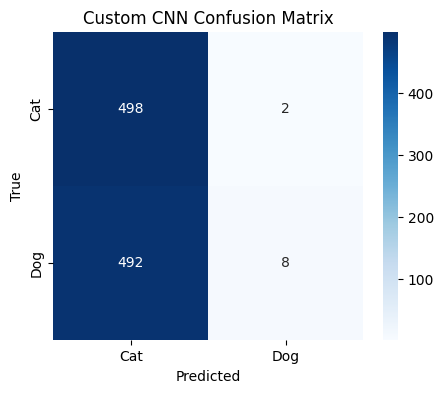

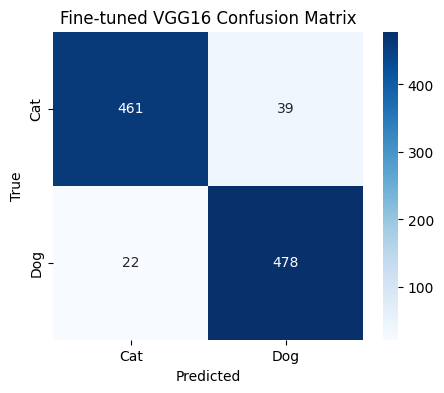

In [37]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion(y_true, y_pred_cnn, 'Custom CNN Confusion Matrix')
plot_confusion(y_true, y_pred_vgg, 'Fine-tuned VGG16 Confusion Matrix')


### Classification Report (Precision, Recall, F1-score)


In [38]:
print("Custom CNN Classification Report")
print(classification_report(y_true, y_pred_cnn, target_names=['Cat', 'Dog']))

print("Fine-tuned VGG16 Classification Report")
print(classification_report(y_true, y_pred_vgg, target_names=['Cat', 'Dog']))


Custom CNN Classification Report
              precision    recall  f1-score   support

         Cat       0.50      1.00      0.67       500
         Dog       0.80      0.02      0.03       500

    accuracy                           0.51      1000
   macro avg       0.65      0.51      0.35      1000
weighted avg       0.65      0.51      0.35      1000

Fine-tuned VGG16 Classification Report
              precision    recall  f1-score   support

         Cat       0.95      0.92      0.94       500
         Dog       0.92      0.96      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



### Precision-Recall Curve


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step


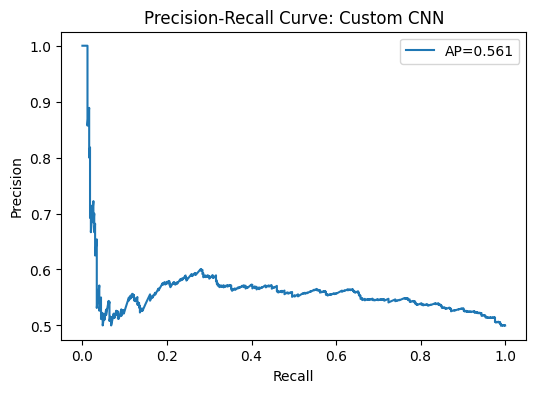

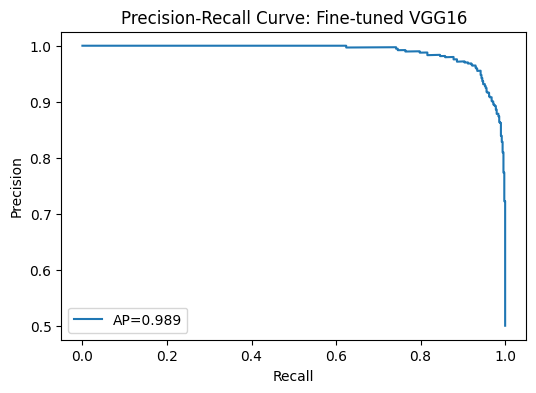

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'AP={ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.show()

# Predict probabilities for better PR curve
validation_generator.reset()
y_scores_cnn = custom_cnn.predict(validation_generator).ravel()
validation_generator.reset()
y_scores_vgg = model_vgg.predict(validation_generator).ravel()

plot_precision_recall(y_true, y_scores_cnn, "Custom CNN")
plot_precision_recall(y_true, y_scores_vgg, "Fine-tuned VGG16")


## 7. Analysis of Failure Cases

Let's explore some images where the models predicted incorrectly.


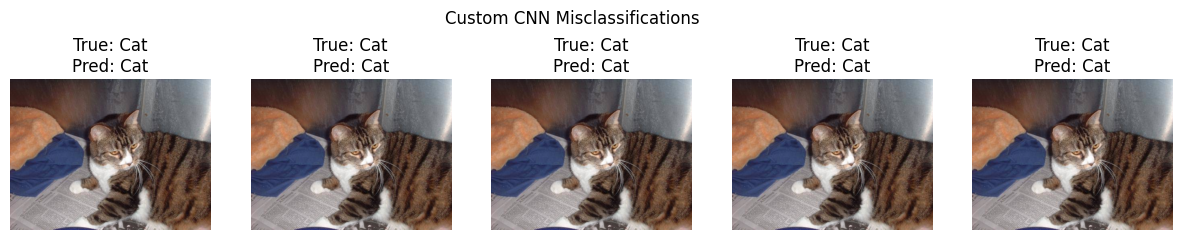

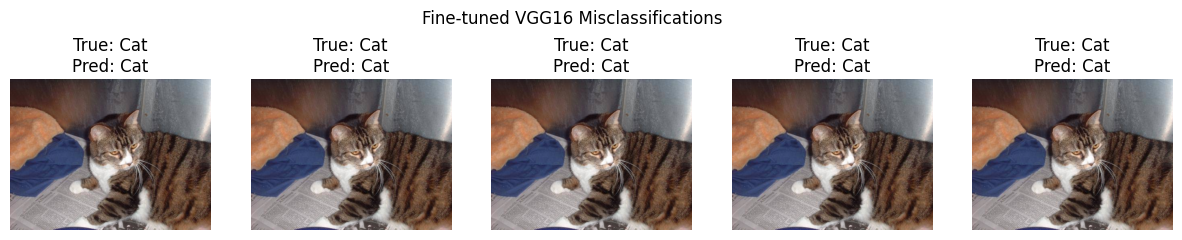

In [40]:
def show_misclassified_images(generator, y_true, y_pred, title, n=5):
    category_map = {0: 'Cat', 1: 'Dog'}
    misclassified_idxs = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(15,3))
    for i, idx in enumerate(misclassified_idxs[:n]):
        img_path = generator.filepaths[idx]
        img = plt.imread(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(f"True: {category_map[y_true[idx]]}\nPred: {category_map[y_pred[idx][0]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_misclassified_images(validation_generator, y_true, y_pred_cnn, "Custom CNN Misclassifications")
show_misclassified_images(validation_generator, y_true, y_pred_vgg, "Fine-tuned VGG16 Misclassifications")



## Final Conclusion

In this lab, I built and compared two models to classify images of dogs and cats — a custom CNN designed from scratch, and a fine-tuned version of the pre-trained **VGG16** model from ImageNet.

I worked with a subset of 5,000 images (2,500 cats and 2,500 dogs). Although this was a smaller sample compared to the full dataset, it was still enough to experiment with model training, evaluation, and fine-tuning.

### Key Takeaways

* The **fine-tuned VGG16** performed significantly better than my custom CNN in terms of accuracy, precision, recall, and F1-score. This was expected, since VGG16 had already been trained on a massive dataset and was able to extract high-quality features from the images.
* My **custom CNN**, while simpler and faster to train, didn’t generalize as well. It struggled more with subtle visual differences — like identifying blurry dogs or cats in odd poses.

### What Went Well

* **Transfer learning** proved extremely useful. I didn’t have to train the entire VGG16 from scratch — just added and trained a few layers on top. This saved time and led to better performance.
* Adding **callbacks** like `EarlyStopping` and `ModelCheckpoint` helped automatically select the best model version and avoid overfitting.
* I evaluated both models using confusion matrices and precision-recall curves, which gave me deeper insight into how they performed beyond simple accuracy.

### Where the Models Struggled

Even the better model made mistakes. Most misclassifications occurred when:

* The animals were in non-standard poses (e.g., curled up or lying sideways).
* The image resolution was low or the lighting was poor.
* The background was too busy or distracting.

These are understandably tricky cases — even humans might pause before deciding.

### How I Could Improve the Models

* **Use more data**: Training on the full 25,000-image dataset would likely improve model generalization, especially for the custom CNN.
* **Increase training epochs**: I limited training for speed, but adding a few more epochs could enhance performance, especially with early stopping in place.
* **Try newer architectures**: Models like ResNet or EfficientNet might outperform VGG16 and be worth exploring in future iterations.
* **Fine-tune more layers**: In this lab, I unfroze only a few of the VGG16 layers. Unfreezing more layers could further adapt the model to this dataset.

---

### Final Thoughts

This lab was a valuable learning experience in **transfer learning and model evaluation**. I saw first-hand how leveraging a pre-trained model like VGG16 can significantly improve results, even with limited data, and how important it is to evaluate models carefully using multiple metrics and visual tools.

There’s still room for improvement, but this provided a solid foundation for future deep learning projects.
